In [1]:
import sys
from __future__ import division

In [2]:
import numpy as np
from phasor.utilities.ipynb.displays import *
from phasor.utilities.ipynb.sympy import *

import declarative

from declarative.bunch import (
    DeepBunch
)

import phasor.math.dispatched as dmath 
#import phasor.math.dispatch_sympy

Populating the interactive namespace from numpy and matplotlib
Sympy version:  1.0


In [3]:
import phasor.utilities.version as version
print(version.foundations_version())

from phasor.utilities.np import logspaced

from phasor import optics
from phasor import base 
from phasor import signals 
from phasor import system
from phasor import readouts 

import scipy.signal

b'2017-09-29 14:18:38 -0400 (bbb2b427cdfd3d3fc1a626fa4fa5404882cc9820)'


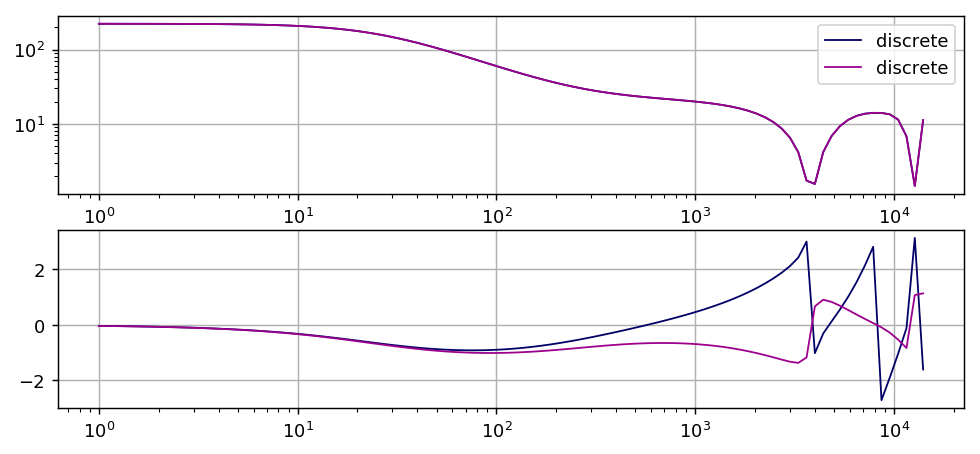

In [152]:
F_nyquist = 16384 / 2
F_AC = F_nyquist * 2 * np.arange(0, 101) / 101
    
F_AC = logspaced(1, 14000, 100)
ZPKz = (
    [
        .9,
        -.3,
        .1+.95j,
        .1-.95j,
    ], 
    [
        #.9,
        .99,
        #.97,
        #-0.03+.95j,
        #-.03-.95j,
        #-.2,
    ], 
    10
)


b,a = scipy.signal.zpk2tf(*ZPKz)


Fb = mplfigB(Nrows=2)
w, h = scipy.signal.freqz_zpk(*ZPKz , worN = F_AC / F_nyquist * np.pi)
F_exact = h
Fb.ax0.loglog(F_AC, abs(h), label = 'discrete')
Fb.ax1.semilogx(F_AC, np.angle(h), label = 'discrete')

w, h = scipy.signal.freqz(b, a , worN = F_AC / F_nyquist * np.pi)
F_exact = h
Fb.ax0.loglog(F_AC, abs(h), label = 'discrete')
Fb.ax1.semilogx(F_AC, np.angle(h), label = 'discrete')

Fb.ax0.legend()

In [153]:
b

array([ 10.     ,  -8.     ,   7.625  ,  -4.935  ,  -2.46375])

In [154]:
R = np.random.randn(len(F_AC)) + 1j*np.random.randn(len(F_AC))
F_noise = F_exact * (1 + R / 100)

In [164]:
F_use = np.concatenate([F_AC, -F_AC])
F_bal = np.concatenate([F_noise, F_noise.conjugate()])

order_b = 4 #len(b)
order_a = 4 #len(a)
Z = np.exp(-1j * np.pi * F_use / F_nyquist)
Z_a = np.vstack([Z**j for j in range(order_a)]).T
Z_a_full = np.vstack([Z**j for j in range(len(F_use))]).T
Z_b = np.vstack([Z**j for j in range(order_b)]).T
Z_b_full = np.vstack([Z**j for j in range(len(F_use))]).T
Z_b.shape



w, h = scipy.signal.freqz(b, [1], worN = F_use / F_nyquist * np.pi)
W = 1/abs(h)**1
#W = 1
M_b = np.einsum('ij,i->ij', Z_b_full,  W * ones_like(F_bal))
M_a = np.einsum('ij,i->ij', Z_a_full,  W * (F_bal))
#M_b = np.einsum('ij,i->ij', Z_b_full, (1/F_exact))
#M_a = np.einsum('ij,i->ij', Z_a, ones_like(F_exact))

ZZ = np.einsum('ij,jk->ik',  np.linalg.pinv(M_b[:,order_b:]), M_a[:, :order_a])
U,S,V = scipy.linalg.svd(ZZ)
print(S)
a_fit = V.T[:order_a, -1]
print(a_fit / a_fit[0])
print(np.roots(a_fit))
print(abs(np.roots(a_fit)))
print()
ZZ = np.einsum('ij,jk->ik', np.linalg.pinv(M_a[:, :order_a]), M_b[:,order_b:])
U,S,V = scipy.linalg.svd(ZZ)
print(S)
S
a_fit = (U[:order_a, -1])
print(a_fit / a_fit[0])
print(np.roots(a_fit))
print(abs(np.roots(a_fit)))

##ZZ = np.einsum('ij,jk->ik', np.linalg.pinv(M_a[:, :])[:order_a,:], M_b[:,order_b:])
ZZ.shape

ZX = np.block([M_a[:, :order_a], -M_b[:, order_b:]])
ZX.shape

[  3.53172379e+13   2.79162867e+08   4.92160291e+07   3.60756470e+03]
[ 1.00000000-0.j         -3.00776673-0.00015565j  3.03342546+0.00031727j
 -1.02546915-0.00016155j]
[ 1.00914794 -1.34086811e-01j  0.98951680 +7.47993996e-07j
  1.00910199 +1.34241712e-01j]
[ 1.01801712  0.9895168   1.01799198]

[ 0.64297943  0.52728774  0.33479153  0.02480355]
[ 1.00000000 -0.00000000e+00j  0.96532536 -2.57547616e-16j
  0.93093214 +5.60105372e-16j  0.88383576 +1.79869922e-16j]
[-0.00401021 -9.60852783e-01j -0.95730494 +6.40112963e-16j
 -0.00401021 +9.60852783e-01j]
[ 0.96086115  0.95730494  0.96086115]


In [118]:
U,S,V = scipy.linalg.svd(ZX)
#print(S)
S
V[:order_a, 3]

array([-0.24691384 -4.10847668e-16j,  0.42004701 -3.83632192e-16j,
       -0.63492235 -5.80520841e-15j, -0.22240903 -9.18141115e-17j,
        0.17803399 -3.99454999e-18j, -0.51778176 +1.12701794e-18j])

In [39]:
fj = F_exact
n = 2
m = 3
N = len(fj)
col = np.fft.ifft(fj)/(N+1);
col = col
row = np.fft.ifft(fj.conjugate()).conjugate()/(N+1);
row = row
Z = scipy.linalg.toeplitz(col,row[0:n]);
[U,S,V] = np.linalg.svd(Z[m:,:]);
arat = V[:,-1];
qj = np.fft.fft(arat, N);
bh = np.fft.ifft(qj * fj);
brat = bh[0:m+0];
pj = np.fft.fft(brat,N+0);
print(S)
V

[ 0.36367789  0.14258429]


array([[-0.75503191+0.j        , -0.65526900-0.02343823j],
       [-0.65568805+0.j        ,  0.75454937+0.02698938j]])

In [84]:
brat / b

array([-0.71065111 +1.19148846e-16j, -0.71065111 -1.80190172e-16j,
       -0.71065111 +1.49918484e-15j])

In [85]:
print(arat / a)
print(arat / arat[0])
arat

[-0.71065111 +6.02900820e-17j -0.71065111 +6.02900820e-17j]
[ 1.00-0.j -0.99-0.j]


array([-0.71065111 +6.02900820e-17j,  0.70354460 -5.96871811e-17j])

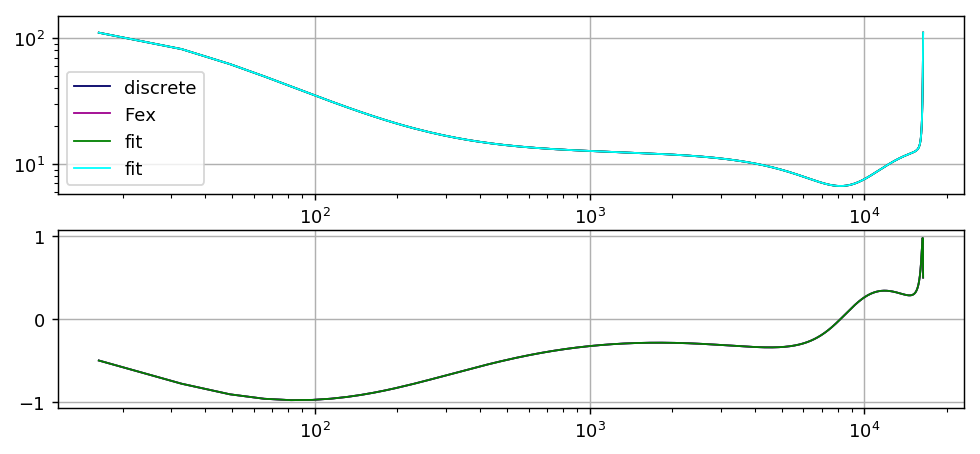

In [86]:
Fb = mplfigB(Nrows=2)
w, h = scipy.signal.freqz(b, a, worN = F_AC / F_nyquist * np.pi)
Fb.ax0.loglog(F_AC, abs(h), label = 'discrete')
Fb.ax1.semilogx(F_AC, np.angle(h), label = 'discrete')

h = F_exact
Fb.ax0.loglog(F_AC, abs(h), label = 'Fex')
Fb.ax1.semilogx(F_AC, np.angle(h), label = 'Fex')

w, h = scipy.signal.freqz(brat, arat, worN = F_AC / F_nyquist * np.pi)
Fb.ax0.loglog(F_AC, abs(h), label = 'fit', color = 'green')
Fb.ax1.semilogx(F_AC, np.angle(h), label = 'fit', color = 'green')

Fb.ax0.loglog(F_AC, abs(pj/qj), label = 'fit', color = 'cyan')
#Fb.ax0.set_xscale('linear')
#Fb.ax1.semilogx(F_AC, np.angle(h), label = 'fit', color = 'green')
Fb.ax0.legend()

In [97]:
F_noisy = F_exact * (1 + R2/10)
W = 1
M_b = np.einsum('ij,i->ij', Z_b_full,  W * ones_like(F_noisy))
M_a = np.einsum('ij,i->ij', Z_a_full,  W * (F_noisy))
#M_b = np.einsum('ij,i->ij', Z_b_full, (1/F_exact))
#M_a = np.einsum('ij,i->ij', Z_a, ones_like(F_exact))
#else:
    #a_z = np.einsum('ij,j->i', Z_a, a_fit)
    #b_z = np.einsum('ij,j->i', Z_b, b_fit)
    #M_b = np.einsum('ij,i->ij', Z_b, 1/F_exact / np.abs(a_z))
    #M_a = Z_a / np.abs(a_z).reshape(-1,1)
    #M_b2 = Z_b / np.abs(b_z).reshape(-1,1)
    #M_a2 = np.einsum('ij,i->ij', Z_a, F_exact / np.abs(b_z))
    #Fb = mplfigB(Nrows=1)
    #w, h = scipy.signal.freqz(b, a, worN = F_AC / F_nyquist * np.pi)
    #Fb.ax0.loglog(F_AC, abs(a_z), label = 'discrete')
    #Fb.ax0.loglog(F_AC, abs(b_z), label = 'discrete')
#    pass

ZZ = np.einsum('ij,jk->ik',  np.linalg.pinv(M_b[:,order_b:]), M_a[:, :order_a])
U,S,V = scipy.linalg.svd(ZZ)
print(S)
a_fit = V[:order_a, -1]
print(a_fit / a_fit[0])

ZZ = np.einsum('ij,jk->ik', np.linalg.pinv(M_a[:, :order_a]), M_b[:,order_b:])
U,S,V = scipy.linalg.svd(ZZ)
print(S)
S
a_fit = (U[:order_a, -1])
print(a_fit / a_fit[0])

##ZZ = np.einsum('ij,jk->ik', np.linalg.pinv(M_a[:, :])[:order_a,:], M_b[:,order_b:])
ZZ.shape

ZX = np.block([M_a[:, :order_a], -M_b[:, order_b:]])
ZX.shape

[ 11.99638871   1.14995556]
[ 1.0000000-0.j  0.9903007-0.j]
[ 0.03937128  0.0156761 ]
[ 1.00000000 +0.00000000e+00j -0.95341624 -4.20503990e-15j]


In [95]:
fj = F_noisy
n = 2
m = 3
N = len(fj)
col = np.fft.ifft(fj)/(N+1);
col = col
row = np.fft.ifft(fj.conjugate()).conjugate()/(N+1);
row = row
Z = scipy.linalg.toeplitz(col,row[0:n]);
[U,S,V] = np.linalg.svd(Z[m:,:]);
arat = V[:,-1];
qj = np.fft.fft(arat, N);
bh = np.fft.ifft(qj * fj);
brat = bh[0:m+0];
pj = np.fft.fft(brat,N+0);
print(S)
V

[ 0.01197244  0.00114766]


array([[-0.70365249 +0.00000000e+00j, -0.71054428 +6.34245856e-17j],
       [ 0.71054428 +0.00000000e+00j, -0.70365249 +6.28094115e-17j]])

In [ ]:
Z,T = scipy.linalg.schur(red3)
Z
@np.vectorize
def fmt(v):
    return "{0:.2e}".format(v)
    
def matrix_markdown(mat, fmt = fmt):
    display(Markdown(
        tabulate.tabulate(
            fmt(mat),
            tablefmt='pipe',
            headers = [''] * red1.shape[0]
    )))
    return
red3.shape

In [ ]:
a

In [ ]:
a_fit

In [ ]:
b


In [ ]:
b_fit